# **Modelling And Evaluating**

## Objectives
* engineer features for modelling and Evaluating

## Inputs

*  The input data, already cleaned and divided into test/train/validating found in:
    * /workspace/mildew-detection/inputs/mildew_dataset/cherry-leaves 
### **Grayscale**
* Same Data but grayscale
    * /workspace/mildew-detection/inputs/mildew_dataset/gray_images
 
## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* I chose to have one rgb and one grayscale to se wich one that gives the best resault



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [6]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [7]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [8]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection'

# Downloading neccessary packages

Packages:

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Setting up the path for train/test/validation

In [3]:
my_data_dir = "inputs/mildew_dataset/cherry-leaves"
train_path = my_data_dir + "/" + "train"
test_path = my_data_dir + "/" + "test"
val_path = my_data_dir + "/" + "validation"

my_data_dir_gray = "inputs/mildew_dataset/gray_images"
train_path_gray = my_data_dir_gray + "/" + "train"
test_path_gray = my_data_dir_gray + "/" + "test"
val_path_gray = my_data_dir_gray + "/" + "validation"

Setting the output for images and other relevant data

In [9]:
version = "v1"
version_two = "v2"
file_path_one = f'output/{version}'
file_path_two = f'output/{version_two}'

# creating output for the rgb images
if "output" in os.listdir(current_dir) and version in os.listdir(current_dir + "/output"):
    print("make a new version")
    pass
else:
    os.makedirs(name=file_path_one)
# creating output for the gray scale images
if "output" in os.listdir(current_dir) and version_two in os.listdir(current_dir + "/output"):
    print("make a new version")
    pass
else:
    os.makedirs(name=file_path_two)

make a new version
make a new version


setting the lable variable

* for RGB images

In [10]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


* for grascale images

In [11]:
labels_gray = os.listdir(train_path_gray)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


In [12]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"output/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

Visualisation of the amount of images in the dataset

* Showing the amount of images in Dataset to get a better understanding of the Dataset
    * Showing with a barplot


---

### **Doing this only RGB because its the same dataset and the numbers won't be different**

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




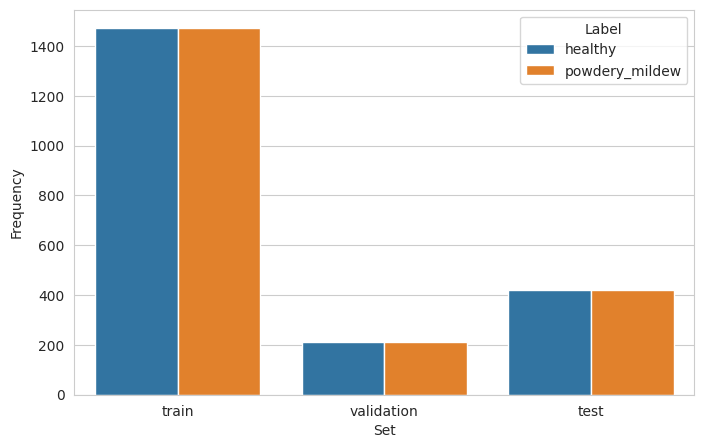

In [17]:

df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path_one}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

Generating images from current images using image agumantation from Tensorflow
* importing neccessary packages for the task 

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
augmented_image_data = ImageDataGenerator(rotation_range=25,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

Augumentation for RGB train set

In [20]:
batch_size = 25  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augumentation for RGB test set

In [21]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augumentation for RGB validation set

In [22]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Plot the augumented Images for Test/train/validation set

* Train set

(25, 256, 256, 3)


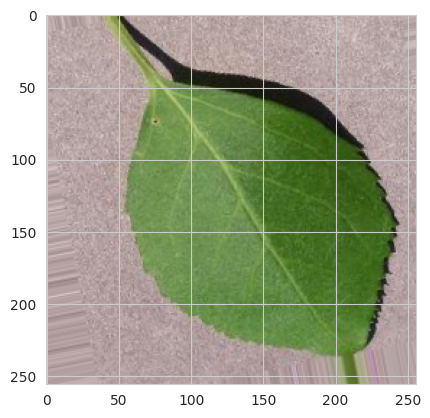

(25, 256, 256, 3)


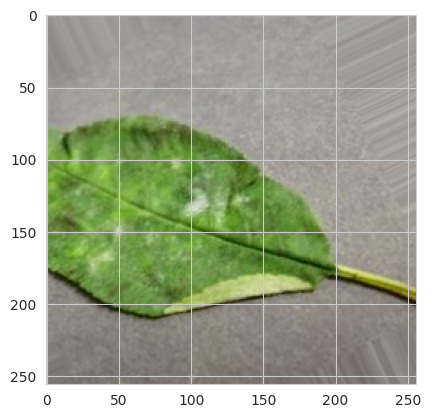

(25, 256, 256, 3)


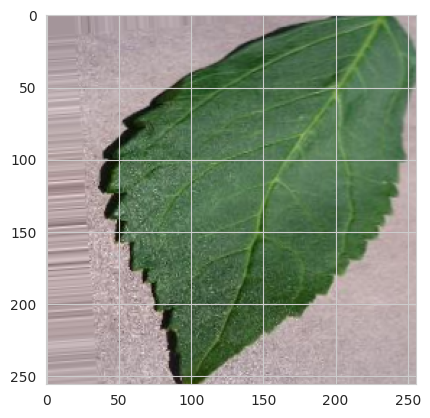

In [23]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

* Test set

(25, 256, 256, 3)


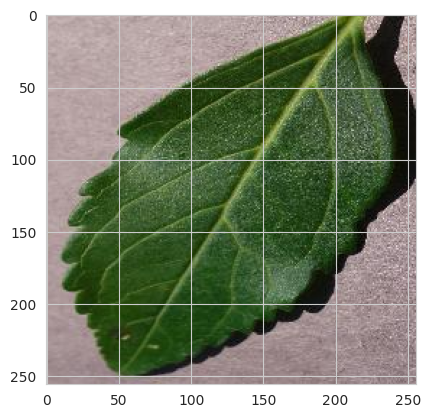

(25, 256, 256, 3)


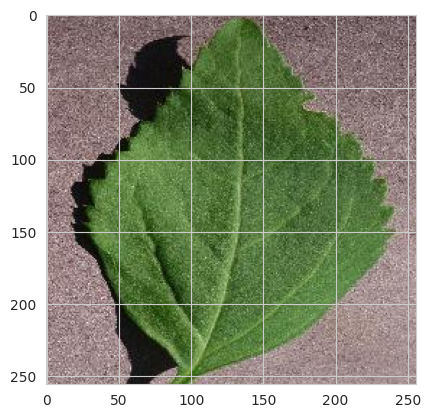

(25, 256, 256, 3)


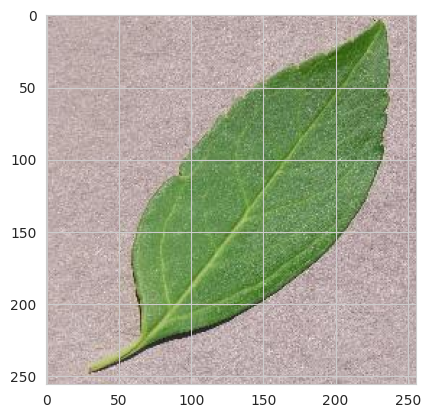

In [24]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

* Validation set

(25, 256, 256, 3)


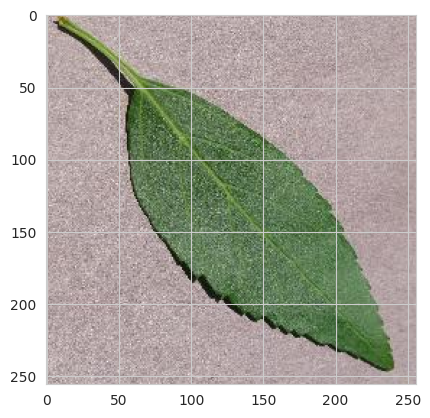

(25, 256, 256, 3)


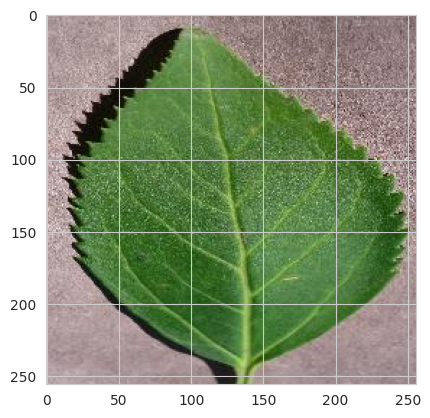

(25, 256, 256, 3)


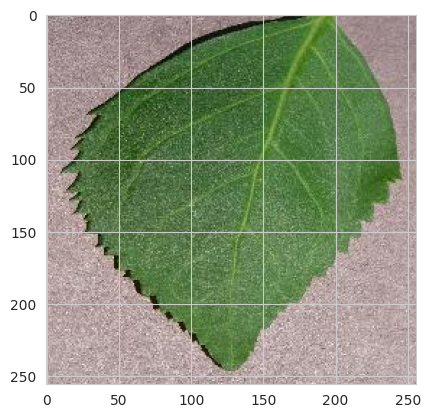

In [25]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Saving the train set indices in "v1"
   * As an pickle file

In [ ]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path_one}/class_indices.pkl")

---

## **Creating The Model**

---

Import neccessary packages for ML

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* Creating the model

In [27]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

* **Summary of the model**

In [28]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

2023-01-18 16:09:51.479683: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Implementing early stopping to reduce risk of overfitting

* starting of with patience=3 and min_delta=0.001 

In [35]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)

### **Fit Model for Model training**

In [36]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25
117/117 [==============================] - 219s 2s/step - loss: 0.3428 - accuracy: 0.8558 - val_loss: 0.1243 - val_accuracy: 0.9667
Epoch 2/25
117/117 [==============================] - 223s 2s/step - loss: 0.0892 - accuracy: 0.9681 - val_loss: 0.3205 - val_accuracy: 0.8881
Epoch 3/25
117/117 [==============================] - 284s 2s/step - loss: 0.0365 - accuracy: 0.9880 - val_loss: 0.0357 - val_accuracy: 0.9929
Epoch 4/25
117/117 [==============================] - 228s 2s/step - loss: 0.0278 - accuracy: 0.9921 - val_loss: 0.0258 - val_accuracy: 0.9929
Epoch 5/25
117/117 [==============================] - 210s 2s/step - loss: 0.0588 - accuracy: 0.9788 - val_loss: 0.0254 - val_accuracy: 0.9929
Epoch 6/25
117/117 [==============================] - 253s 2s/step - loss: 0.0340 - accuracy: 0.9908 - val_loss: 0.0664 - val_accuracy: 0.9905
Epoch 7/25
117/117 [==============================] - 220s 2s/step - loss: 0.0116 - accuracy: 0.9990 - val_loss: 0.0102 - val_accuracy: 0.9929

* Saving the model

In [37]:
model.save('output/v1/mildew_detection_model.h5')


---

### **Learning curve**
* Based on the model from above

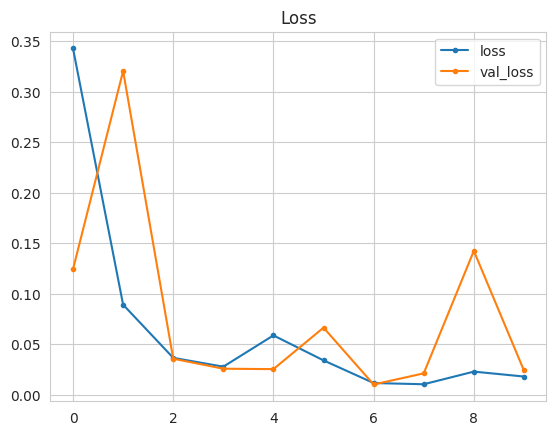

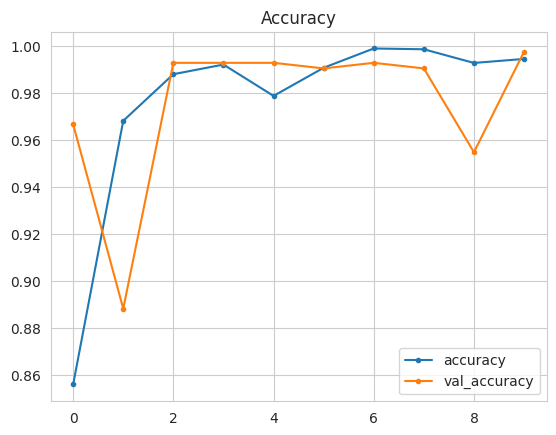

In [38]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path_one}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path_one}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)
